## Aortic Valve Label Consistency Workbook

In [1]:
import nibabel as nib
import numpy as np
import os 
import itk
import numpy as np
from vtk import vtkPolyDataReader, vtkExtractSelection, vtkSelection, vtkSelectionNode
from vtkmodules.util import numpy_support

### Copy alignment labels from inference segmentation to manual segmentation

In [2]:

file1 = '/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/BetweenPatient/img11_bav013.nii.gz'
file2 = '/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/BetweenPatient/seg11_bav013_SYS_NY_AMP_SA_LAS.nii.gz'

img1 = nib.load(file1)
img2 = nib.load(file2)
data1 = img1.get_fdata()
data2 = img2.get_fdata()
data2[(data1 ==1)]= 5
data2[(data1 ==2)]= 6
data2[(data1 ==4)]= 7
updated_img2 = nib.Nifti1Image(data2, img2.affine)
nib.save(updated_img2, '/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/BetweenPatient/seg11_bav013_LAS.nii.gz')


### Non-python Tasks
1. Convert refined segmentation to vtk polydata using vtklevelset
2. Use MatLab reorient_pts function to reorient root by IAS and normal vector


### Convert VTKPolyData to Nifti Image and Perform Post-Processing

In [3]:
import vtk, itk, nibabel as nib
import numpy as np
from vtkmodules.util import numpy_support

# --- read poly-data ----------------------------------------------------------
poly_reader = vtk.vtkPolyDataReader()
poly_reader.SetFileName(
    "/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/BetweenPatient/seg11_bav013_reoriented.vtk")
poly_reader.Update()
poly = poly_reader.GetOutput()

labels = numpy_support.vtk_to_numpy(poly.GetPointData().GetScalars())
uniq   = np.unique(labels)

# --- allocate empty label volume --------------------------------------------
spacing = (0.5, 0.5, 0.5)                        # mm
bounds  = poly.GetBounds() 
# phys_extent = np.array([90.0, 90.0, 100.0])# xmin,xmax, …,zmax
size   =  np.array([90, 90, 100])  
origin = - (size - 1)* spacing / 2.0 

lab_img = itk.Image[itk.UL, 3].New()             # unsigned long (≥ uint16)
lab_img.SetRegions(tuple(int(v) for v in size))
lab_img.SetSpacing(spacing)
lab_img.SetOrigin(origin)
lab_img.Allocate();  lab_img.FillBuffer(0)

# Get writable NumPy view (shape = [z,y,x])
lab_np = itk.GetArrayViewFromImage(lab_img)

# --- paint each mesh point into the volume -----------------------------------
for pid, lbl in enumerate(labels):
    if lbl == 0:            # background in the mesh → skip
        continue
    x, y, z = poly.GetPoint(pid)

    ix = int(round((x - origin[0]) / spacing[0]))
    iy = int(round((y - origin[1]) / spacing[1]))
    iz = int(round((z - origin[2]) / spacing[2]))

    # bounds-check (robust to rounding at edges)
    if (0 <= ix < size[0]) and (0 <= iy < size[1]) and (0 <= iz < size[2]):
        lab_np[iz, iy, ix] = int(lbl)

# --- write to NIfTI ----------------------------------------------------------
#  option A: itk.imwrite  (ITK ≥ 5.3)
# itk.imwrite(lab_img, "/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/reoriented_rasterized.nii.gz")

#  option B: nibabel  (if you want a custom affine / header)
affine = np.diag(list(spacing) + [1.0])
affine[:3, 3] = origin
nib.save(
    nib.Nifti1Image(lab_np.astype(np.uint16), affine),
    "/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/BetweenPatient/seg11_bav013_reoriented.nii.gz")


In [4]:
##Post-processing rasterized image
import nibabel as nib
import numpy as np
import os
from scipy.ndimage import binary_erosion, binary_dilation

# Load the rasterized image
rasterized_image_path = '/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/BetweenPatient/seg11_bav013_reoriented.nii.gz'
rasterized_img = nib.load(rasterized_image_path)
rasterized_data = rasterized_img.get_fdata()
# Define the labels to be processed
labels_to_process = np.unique(rasterized_data)  # Labels for the leaflets
# Iterate through each label and apply morphological operations
for label in labels_to_process:
    if label == 0:  # Skip background
        continue
    # Create a binary mask for the current label
    binary_mask = (rasterized_data == label)
    
    # Apply binary erosion followed by dilation
    dilated_mask = binary_dilation(binary_mask, structure=np.ones((5, 5, 5)), iterations=3)
    eroded_mask = binary_erosion(dilated_mask, structure=np.ones((5, 5, 5)), iterations=3)
   
    
    # Update the rasterized data with the processed mask
    rasterized_data[eroded_mask] = label

# Save the processed rasterized image
processed_img = nib.Nifti1Image(rasterized_data, rasterized_img.affine)
nib.save(processed_img, '/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/BetweenPatient/seg11_bav013_reoriented.nii.gz')


### Label Consistency Function

In [2]:
def label_consistency_check(seg_1, seg_2):
    # Load the rasterized image and original segmentation
    seg1_img = nib.load(seg_1)
    seg2_img = nib.load(seg_2)
    seg1_data = seg1_img.get_fdata()
    seg2_data = seg2_img.get_fdata()
    true_dsces = []
    other_dsces = [] 
    # Get unique labels in both segmentations
    labels = [1,2,3,5,6,7]
    if seg1_data.shape != seg2_data.shape:
        print(f"{seg_1} has different shape than {seg_2}.")
        return 0

    else: 
        for label in labels:
            if label == 0:
                continue
            im1 = seg1_data == label
            im2 = seg2_data == label
            intersection = np.logical_and(im1, im2)
            if im1.sum() + im2.sum() == 0:
                return 1 if intersection.sum() == 0 else 0
            true_dsc = 2 * intersection.sum()/ (im1.sum() + im2.sum())
            print(f"Label {label}: DSC = {true_dsc:.4f}")
            other_labels = [l  for l in labels if l != label]
            for other_label in other_labels:
                im1_other = seg1_data == other_label
                im2_other = seg2_data == label
                intersection_other = np.logical_and(im1_other, im2_other)
                if im1_other.sum() + im2_other.sum() == 0:
                    return 1 if intersection_other.sum() == 0 else 0
                other_dsc = 2 * intersection_other.sum() / (im1_other.sum() + im2_other.sum())
                print(f"Label {label}: Other DSC = {other_dsc:.4f}")
            true_dsces.append(true_dsc)
            other_dsces.append(other_dsc)
        if np.mean(true_dsces) < np.mean(other_dsces):
            print("Labels are not consistent.")
            return 0
        else:
            return 1
        


In [4]:
ok = label_consistency_check('/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/seg28_bav016_LAS_reoriented.nii.gz', '/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/LabelConsistencyCheck/BetweenPatient/seg11_bav013_reoriented.nii.gz')

Label 1: DSC = 0.1179
Label 1: Other DSC = 0.0214
Label 1: Other DSC = 0.0002
Label 2: DSC = 0.0903
Label 2: Other DSC = 0.0000
Label 2: Other DSC = 0.0142
Label 3: DSC = 0.2548
Label 3: Other DSC = 0.0341
Label 3: Other DSC = 0.0000


In [ ]:

for file in os.listdir('/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333'):
    if file.endswith('.nii.gz'):
        for f in os.listdir('/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/mesh_distanceanalysis/all_segmentations'):
            if f.endswith('.nii.gz'):
                result = label_consistency_check(os.path.join('/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333', file), os.path.join('/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/mesh_distanceanalysis/all_segmentations', f))
                print(f"Comparing {file} and {f}: {'Consistent' if result == 1 else 'Not Consistent'}")

1


In [4]:
import nibabel as nib
import numpy as np

def dice(mask1, mask2):
    """Compute Dice between two boolean masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    size1 = mask1.sum()
    size2 = mask2.sum()
    if size1 + size2 == 0:
        # no voxels in either mask -> define DSC = 1 (perfectly 'matching absence')
        return 1.0
    return 2.0 * intersection / (size1 + size2)


def label_consistency_check(seg_1, seg_2, labels=(1, 2, 3, 5, 6, 7)):
    """
    Compare manual (seg_1) and automatic (seg_2) segmentations.

    Returns:
        results: dict keyed by label with:
            {
              'true_dsc': float,
              'max_other_dsc': float,
              'is_correct': bool
            }
    """
    seg1_img = nib.load(seg_1)
    seg2_img = nib.load(seg_2)
    seg1_data = seg1_img.get_fdata()
    seg2_data = seg2_img.get_fdata()

    if seg1_data.shape != seg2_data.shape:
        print(f"{seg_1} has different shape than {seg_2}. Skipping.")
        return None

    results = {}

    for label in labels:
        gt_mask = seg1_data == label  # assume seg_1 is "manual"
        if gt_mask.sum() == 0:
            # Label not present in GT for this case; skip or mark as NaN
            results[label] = {
                "true_dsc": np.nan,
                "max_other_dsc": np.nan,
                "is_correct": np.nan
            }
            continue

        # Dice with the "correct" automatic label
        pred_mask_correct = seg2_data == label
        true_dsc = dice(gt_mask, pred_mask_correct)

        # Dice with "incorrect" automatic labels
        other_labels = [l for l in labels if l != label]
        other_dsces = []
        for other_label in other_labels:
            pred_mask_other = seg2_data == other_label
            other_dsces.append(dice(gt_mask, pred_mask_other))

        max_other_dsc = np.max(other_dsces) if len(other_dsces) > 0 else 0.0

        is_correct = true_dsc >= max_other_dsc  # label assignment correctness

        results[label] = {
            "true_dsc": float(true_dsc),
            "max_other_dsc": float(max_other_dsc),
            "is_correct": bool(is_correct)
        }

    return results


In [15]:
import os
import numpy as np
import pandas as pd

manual_dir = "/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_testlabels/final_segmentations"
auto_dir   = "/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333"

labels = [1, 2, 3, 5, 6, 7]

# List only NIfTI files
manual_files = [f for f in os.listdir(manual_dir) if f.endswith(".nii.gz")]
auto_files   = [f for f in os.listdir(auto_dir)   if f.endswith(".nii.gz")]

# Build maps from case_id (filename without extension) to filename
manual_map = {f.replace('seg','img').replace("_LAS.nii.gz", ""): f for f in manual_files}
auto_map   = {f.replace(".nii.gz", ""): f for f in auto_files}

# Common case_ids present in both
common_case_ids = sorted(set(manual_map.keys()) & set(auto_map.keys()))
print(f"Found {len(common_case_ids)} cases in common.")

rows = []

for case_id in common_case_ids:
    seg_1 = os.path.join(manual_dir, manual_map[case_id])  # manual
    seg_2 = os.path.join(auto_dir,   auto_map[case_id])    # auto

    results = label_consistency_check(seg_1, seg_2, labels=labels)
    if results is None:
        # e.g. shape mismatch or load issue
        print(f"Skipping {case_id} due to None results.")
        continue

    for label in labels:
        res = results[label]

        # Skip labels that don't appear in GT for that case
        if np.isnan(res["true_dsc"]):
            continue

        rows.append({
            "case_id": case_id,
            "label": label,
            "true_dsc": res["true_dsc"],
            "max_other_dsc": res["max_other_dsc"],
            "is_correct": res["is_correct"],
        })

df = pd.DataFrame(rows)
print(df.head())



Found 699 cases in common.
/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_testlabels/final_segmentations/seg01_tav025_LAS.nii.gz has different shape than /Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333/img01_tav025.nii.gz. Skipping.
Skipping img01_tav025 due to None results.
/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_testlabels/final_segmentations/seg02_tav025_LAS.nii.gz has different shape than /Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333/img02_tav025.nii.gz. Skipping.
Skipping img02_tav025 due to None results.
/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_testlabels/final_segmentations/seg03_tav029_LAS.nii.gz has different shape than /Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333/img03_tav029.nii.gz. Skipping.
Skipping img03_tav029 due to None results.
/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_te

In [16]:
df

,case_id,label,true_dsc,max_other_dsc,is_correct
0,img01_bav004,1,0.706952,0.030359,True
1,img01_bav004,2,0.728037,0.046236,True
2,img01_bav004,3,0.751100,0.037980,True
3,img01_bav004,5,0.666756,0.058710,True
4,img01_bav004,6,0.629938,0.053268,True
...,...,...,...,...,...
3869,img45_tav041,2,0.710855,0.040051,True
3870,img45_tav041,3,0.672704,0.076452,True
3871,img45_tav041,5,0.452501,0.073496,True
3872,img45_tav041,6,0.543352,0.045627,True


Overall assignment accuracy: 0.9380485286525555


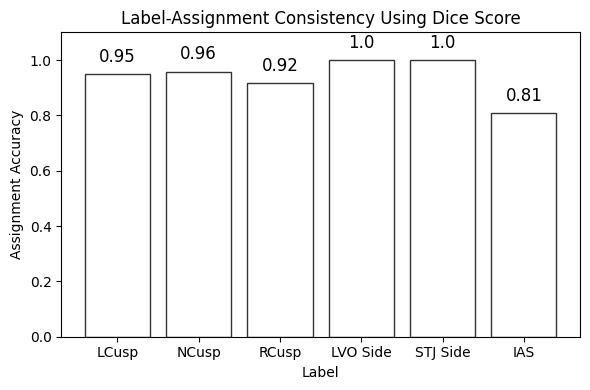

In [45]:
# Overall label-assignment accuracy
overall_accuracy = df["is_correct"].mean()
print("Overall assignment accuracy:", overall_accuracy)

# Per-label accuracy
per_label_accuracy = df.groupby("label")["is_correct"].mean()
label_std = df.groupby("label")["is_correct"].std()

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
bars= plt.bar(['LCusp', 'NCusp', 'RCusp', 'LVO Side', 'STJ Side', 'IAS'], per_label_accuracy.values, facecolor='none', edgecolor='0.2', linewidth=1.0, capsize=5)
plt.xlabel("Label")
plt.ylabel("Assignment Accuracy")
for bar, err in zip(bars, label_std):
    yval = bar.get_height()
    error = err
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.03, f'{round(yval, 2)}', va='bottom', ha='center', fontsize=12, color='black')
    # plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1 + error, 'ns', va='bottom', ha='center', fontsize=12, color='black')
plt.title("Label-Assignment Consistency Using Dice Score")
plt.ylim(0,1.1)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.tight_layout()
plt.show()


In [29]:
import nibabel as nib
import numpy as np

def center_of_mass(mask):
    """
    Compute the (voxel-space) center of mass of a boolean mask.
    Returns a length-3 numpy array or None if the mask is empty.
    """
    idx = np.argwhere(mask)
    if idx.size == 0:
        return None
    return idx.mean(axis=0)  # (z, y, x) in voxel coordinates


def label_com_consistency_check(seg_1, seg_2, labels=(1, 2, 3, 5, 6, 7)):
    """
    Compare manual (seg_1) and automatic (seg_2) segmentations using
    center-of-mass distances.

    For each GT label:
        - true_dist: distance between CoM(manual == label) and CoM(auto == label)
        - min_other_dist: minimum distance between CoM(manual == label)
                          and CoM(auto == k) for k != label
        - is_correct: true_dist <= min_other_dist

    Returns:
        results: dict keyed by label with:
            {
              'true_dist': float or np.nan,
              'min_other_dist': float or np.nan,
              'is_correct': bool or np.nan
            }
    """
    seg1_img = nib.load(seg_1)  # manual
    seg2_img = nib.load(seg_2)  # auto
    seg1_data = seg1_img.get_fdata()
    seg2_data = seg2_img.get_fdata()

    if seg1_data.shape != seg2_data.shape:
        print(f"{seg_1} has different shape than {seg_2}. Skipping.")
        return None

    results = {}

    for label in labels:
        gt_mask = seg1_data == label  # ground-truth label

        # If the label doesn't appear in GT, skip it for this case
        if gt_mask.sum() == 0:
            results[label] = {
                "true_dist": np.nan,
                "min_other_dist": np.nan,
                "is_correct": np.nan
            }
            continue

        com_gt = center_of_mass(gt_mask)

        # CoM for the "correct" auto label
        pred_mask_correct = seg2_data == label
        com_auto_correct = center_of_mass(pred_mask_correct)

        if com_auto_correct is None:
            # auto completely missed this label → treat as infinitely far
            true_dist = np.inf
        else:
            true_dist = np.linalg.norm(com_gt - com_auto_correct)

        # Distances to all "wrong" auto labels
        other_labels = [l for l in labels if l != label]
        other_dists = []
        for other_label in other_labels:
            pred_mask_other = seg2_data == other_label
            com_auto_other = center_of_mass(pred_mask_other)
            if com_auto_other is None:
                # no voxels for that wrong label, treat as very far
                dist = np.inf
            else:
                dist = np.linalg.norm(com_gt - com_auto_other)
            other_dists.append(dist)

        if len(other_dists) > 0:
            min_other_dist = float(np.min(other_dists))
        else:
            min_other_dist = np.inf

        is_correct = bool(true_dist <= min_other_dist)

        results[label] = {
            "true_dist": float(true_dist),
            "min_other_dist": float(min_other_dist),
            "is_correct": is_correct
        }

    return results


In [31]:
rows = []

for case_id in common_case_ids:  # however you're defining this
    seg_1 = os.path.join(manual_dir, manual_map[case_id])  # manual
    seg_2 = os.path.join(auto_dir,   auto_map[case_id]) 

    results = label_com_consistency_check(seg_1, seg_2, labels=labels)
    if results is None:
        continue

    for label in labels:
        res = results[label]
        if np.isnan(res["true_dist"]):
            continue

        rows.append({
            "case_id": case_id,
            "label": label,
            "true_dist": res["true_dist"],
            "min_other_dist": res["min_other_dist"],
            "is_correct_com": res["is_correct"],  # CoM-based correctness
        })

df_com = pd.DataFrame(rows)


/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_testlabels/final_segmentations/seg01_tav025_LAS.nii.gz has different shape than /Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333/img01_tav025.nii.gz. Skipping.
/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_testlabels/final_segmentations/seg02_tav025_LAS.nii.gz has different shape than /Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333/img02_tav025.nii.gz. Skipping.
/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_testlabels/final_segmentations/seg03_tav029_LAS.nii.gz has different shape than /Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333/img03_tav029.nii.gz. Skipping.
/Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/Processed_testlabels/final_segmentations/seg10_tav029_LAS.nii.gz has different shape than /Users/silvaniamin/Documents/PICSL/aorticvalveleafletproject/inference3333/img

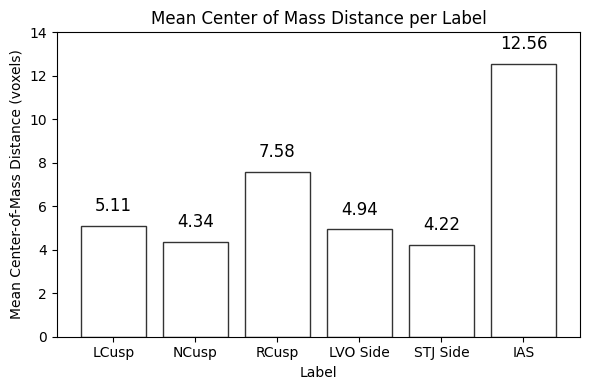

In [39]:
import pandas as pd

# Mean true_dist per label
df_com["true_dist_clean"] = df_com["true_dist"].replace(np.inf, np.nan)
mean_true_dist = df_com.groupby("label")["true_dist_clean"].mean()



import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

bars = plt.bar(['LCusp', 'NCusp', 'RCusp', 'LVO Side', 'STJ Side', 'IAS'], mean_true_dist.values, facecolor='none', edgecolor='0.2', linewidth=1.0, capsize=5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{round(yval, 2)}', va='bottom', ha='center', fontsize=12, color='black')
plt.xlabel("Label")
plt.ylim(0, 14)
plt.ylabel("Mean Center-of-Mass Distance (voxels)")
plt.title("Mean Center of Mass Distance per Label")
plt.tight_layout()
plt.show()



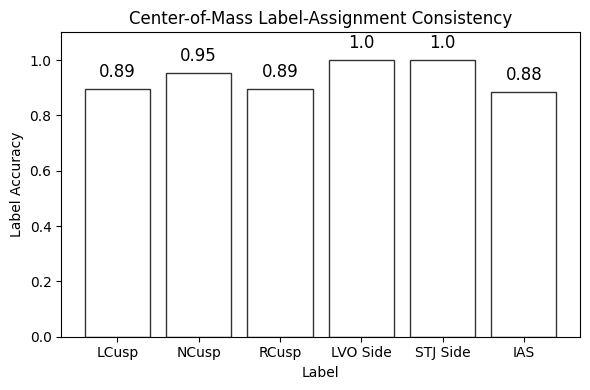

In [43]:
per_label_acc_com = df_com.groupby("label")["is_correct_com"].mean()
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
bars = plt.bar(['LCusp', 'NCusp', 'RCusp', 'LVO Side', 'STJ Side', 'IAS'], per_label_acc_com.values,facecolor='none', edgecolor='0.2', linewidth=1.0)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.03, f'{round(yval, 2)}', va='bottom', ha='center', fontsize=12, color='black')
plt.ylim(0, 1.1)
plt.xlabel("Label")
plt.ylabel("Label Accuracy")
plt.title("Center-of-Mass Label-Assignment Consistency")
plt.tight_layout()
plt.show()


In [13]:
import os 

def study_idlist(path):
    study_ids = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.nii.gz'):
                study_id = file.split('_')[1]
                if study_id not in study_ids:
                    study_ids.append(study_id)
    return study_ids


studies = study_idlist('/Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/ConvertedTEEimages-LAS/TEE_Manual_AV_Segmentations/TAV_Systole')
print(sorted(studies))

['tav001', 'tav002', 'tav006', 'tav007', 'tav008', 'tav009', 'tav011', 'tav012', 'tav014', 'tav016', 'tav017', 'tav018', 'tav020', 'tav022', 'tav024', 'tav027', 'tav029', 'tav030', 'tav031', 'tav033', 'tav034', 'tav035', 'tav036', 'tav037', 'tav038', 'tav039', 'tav040', 'tav041', 'tav042', 'tav043', 'tav044', 'tav048']


In [14]:
import shutil
systole_target = '/Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/ConvertedTEEimages-LAS/TEE_Manual_AV_Segmentations/TAV_Diastole'
not_ok_list = []
for study in studies:
    comparison_folder = '/Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/ConvertedTEEimages-LAS/TEE_Manual_AV_Segmentations/TAV_Systole'
    for file in os.listdir(comparison_folder):
        if file.endswith('.nii.gz') and file.split('_')[1]==study:
            dias_file = file
            dias_file_frame = dias_file.split('_')[0][3:5]
    study = study[0:3] + study[4:]  # Remove the extra 0 from the study ID
    segfolder = f'/Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/TAVs/{study}'
            
    for file in os.listdir(segfolder): 
        if file.endswith('LAS.nii.gz') and file.startswith('seg'):
            sys_path = os.path.join(segfolder, file)
            sys_file = file
            sys_file_frame = sys_file.split('_')[0][3:5]
            if sys_file_frame != dias_file_frame:
                ok = label_consistency_check(sys_path, os.path.join(comparison_folder, dias_file))
                print(f"Label consistency for {file}: {'OK' if ok else 'Not OK'}")
                if ok:
                    shutil.copy(sys_path, os.path.join(systole_target, file))
                if not ok:
                    not_ok_list.append(file)    
            if not sys_path.endswith('LAS.nii.gz'):
                continue
            


            
    

Label 1: DSC = 0.1254
Label 1: Other DSC = 0.0356
Label 1: Other DSC = 0.0187
Label 2: DSC = 0.0004
Label 2: Other DSC = 0.0000
Label 2: Other DSC = 0.0000
Label 3: DSC = 0.0424
Label 3: Other DSC = 0.0000
Label 3: Other DSC = 0.0417
Label consistency for seg09_tav48_NY_SA_LAS.nii.gz: OK
Label 1: DSC = 0.0249
Label 1: Other DSC = 0.2763
Label 1: Other DSC = 0.0000
Label 2: DSC = 0.0353
Label 2: Other DSC = 0.0480
Label 2: Other DSC = 0.2203
Label 3: DSC = 0.0000
Label 3: Other DSC = 0.2244
Label 3: Other DSC = 0.0000
Labels are not consistent.
Label consistency for seg10_tav40_NY_SA_LAS.nii.gz: Not OK
Label 1: DSC = 0.2763
Label 1: Other DSC = 0.0249
Label 1: Other DSC = 0.0000
Label 2: DSC = 0.0480
Label 2: Other DSC = 0.0353
Label 2: Other DSC = 0.2203
Label 3: DSC = 0.0000
Label 3: Other DSC = 0.0000
Label 3: Other DSC = 0.2244
Labels are not consistent.
Label consistency for seg10_tav40_NY_SA_AMP_LAS.nii.gz: Not OK
Label 1: DSC = 0.3008
Label 1: Other DSC = 0.0420
Label 1: Other DS

In [15]:
studies_added = []
studies_notadded = []

for file in os.listdir(systole_target):
    study = file.split('_')[1]
    if len(study) == 6:
        study = study[0:3] + study[4:] 
        # print(study)# Remove the extra 0 from the study ID
    studies_added.append(study)
for item in not_ok_list:
    study = item.split('_')[1]
    if len(study) == 6:
        study = study[0:3] + study[4:]
        # print(study)
    studies_notadded.append(study)
    

diff = (set(studies_notadded) - set(studies_added))
print("Studies missing from systole target:", sorted(diff))

Studies missing from systole target: ['TEE', 'tav33', 'tav36', 'tav40', 'tav41', 'tav42']


In [16]:
studies_dias = []
for file in os.listdir(comparison_folder):
    if file.endswith('.nii.gz'):
        study = file.split('_')[1]
    
        if len(study) == 6:
            study = study[0:3] + study[4:]
        studies_dias.append(study)

diff = (set(studies_dias) - set(studies_added))
print("Studies missing from systole target:", sorted(diff))

Studies missing from systole target: ['tav01', 'tav02', 'tav06', 'tav07', 'tav08', 'tav09', 'tav11', 'tav12', 'tav14', 'tav16', 'tav17', 'tav18', 'tav22', 'tav27', 'tav29', 'tav30', 'tav31', 'tav33', 'tav36', 'tav37', 'tav38', 'tav39', 'tav40', 'tav41', 'tav42']


In [46]:
for file in os.listdir(systole_target):
    study = file.split('_')[1]
    seg = file.split('_')[0]
    if len(study) == 6:
        print(study)
        continue
    else:
        study = study[0:3] + '0' + study[4:]
        if study == 'Sto0e':
            print(f"{file}")
        print(study)
    new_file = f"{seg}_{study}_LAS.nii.gz"
    os.rename(os.path.join(systole_target, file), os.path.join(systole_target, new_file))


bav017
bav043
bav019
bav052
bav015
bav01
bav035
bav053
bav016
bav060
bav02
bav020
bav045
bav028
bav006
bav039
bav024
bav037
bav050
bav051
bav031
bav011
bav008
bav047
bav014
bav044
bav056
.DS_Sto0e_LAS.nii.gz
Sto0e
bav027
bav041
bav004
bav013
bav005
bav046
bav03
bav007
bav012
bav095
bav038
bav032
bav047
bav034


In [ ]:
import random

# folder containing the aligned segmentation NIfTI files
seg_folder = ""

# list all .nii and .nii.gz files
seg_files = [
    f for f in os.listdir(seg_folder)
    if f.endswith(".nii") or f.endswith(".nii.gz")
]

for seg1 in seg_files:
    # pick another random file that is not the same
    candidates = [f for f in seg_files if f != seg1]
    if not candidates:
        continue

    seg2 = random.choice(candidates)
    path1 = os.path.join(seg_folder, seg1)
    path2 = os.path.join(seg_folder, seg2)

    # run the consistency check
    ok = label_consistency_check(path1, path2)
    if ok == 0:
        print(f"Inconsistency between {seg1} and {seg2}")

## LVO Check 

In [ ]:

import SimpleITK as sitk
import numpy as np
def ensure_three_points(pts_phys, spacing):
    """
    If we only have two physical‐space points, fabricate a third one
    that lies on the same z-level but is not collinear so we can fit a
    plane.  The extra point is placed one voxel in +X (RAS) from the
    mid-point.

    Parameters
    ----------
    pts_phys : list[np.ndarray]
        2 × 3 or 3 × 3 array-like of x,y,z coordinates.
    spacing : np.ndarray
        Physical spacing (mm) of the volume in x,y,z order.
    """
    if len(pts_phys) == 3:
        return pts_phys                    # nothing to do

    if len(pts_phys) != 2:
        raise ValueError("Need exactly 2 or 3 leaflet points")

    p0, p1 = pts_phys
    mid    = 0.5 * (p0 + p1)
    fudge  = np.array([spacing[0], 0, 0])  # one voxel to the right
    p2     = mid  + fudge 

    return [p0, p1, p2]

def plane_from_points(p0: np.ndarray,
                      p1: np.ndarray,
                      p2: np.ndarray,
                      *,
                      rtol: float = 1e-6) -> tuple[np.ndarray, float]:
    """
    Fit a plane through three non-collinear 3-D points.

    Parameters
    ----------
    p0, p1, p2 : array-like, shape (3,)
        Coordinates of three distinct points in ℝ³.
    rtol : float, optional
        Relative tolerance used to detect degeneracy (collinearity).

    Returns
    -------
    n : (3,) ndarray
        Unit normal vector of the plane (right-hand rule).
    d : float
        Offset such that for any point x on the plane:  n · x + d = 0.

    Raises
    ------
    ValueError
        If the three points are (numerically) collinear.
    """
    # Convert to float64 arrays
    p0, p1, p2 = map(lambda p: np.asarray(p, dtype=np.float64), (p0, p1, p2))

    # Two edge vectors in the plane
    v1, v2 = p1 - p0, p2 - p0

    # Normal is their cross-product
    n = np.cross(v1, v2)
    norm = np.linalg.norm(n)

    if norm < rtol * max(np.linalg.norm(v1), np.linalg.norm(v2)):
        raise ValueError("The three points are collinear; plane undefined.")

    n /= norm                       # unit length
    d = - np.dot(n, p0)              # plane offset

    return n, d


def crop_below_leaflet_plane_nifti(seg_path,
                                   out_path,
                                   leaflet_labels=(1, 2, 3),
                                   margin_vox=5,
                                   axis='z'):
    """
    Load a NIfTI segmentation, clip everything margin_vox below the
    leaflet plane, and save the cleaned label-map.
    """
    img = sitk.ReadImage(seg_path)
    arr = sitk.GetArrayFromImage(img)        # z,y,x indexing
    spacing = np.array(img.GetSpacing())     # x,y,z order!
    origin  = np.array(img.GetOrigin())
    direction = np.array(img.GetDirection()).reshape(3, 3)

    # Map axis name to voxel dimension
    axis_idx = dict(x=2, y=1, z=0)[axis.lower()]

    # 1. collect the “lowest” voxel indices for each leaflet
    pts_vox = []
    for lab in leaflet_labels:
        coords = np.argwhere(arr == lab)
        low_slice = coords[:, axis_idx].min()
        pts_vox.append(coords[coords[:, axis_idx] == low_slice][0])

    pts_phys = [direction @ (p[::-1] * spacing) + origin for p in pts_vox]  # to x,y,z phys

    # 2. plane fit
    pts_phys = ensure_three_points(pts_phys, spacing)
    n, d = plane_from_points(*pts_phys)

    # 3. distance transform & masking
    zz, yy, xx = np.indices(arr.shape)
    vox = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)        # x,y,z order
    phys = (direction @ (vox * spacing[::-1]).T).T + origin
    dist = (phys @ n + d).reshape(arr.shape)                   # signed distance

    # Keep everything ABOVE (-) the plane + margin
    mask = dist < (margin_vox * spacing[axis_idx]) * (-n[axis_idx])
    arr[mask] = 0

    out_img = sitk.GetImageFromArray(arr)
    out_img.CopyInformation(img)
    sitk.WriteImage(out_img, out_path)


crop_below_leaflet_plane_nifti(
    seg_path="/Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/bav38/seg09_bav038_NY_AMP_SA_LAS.nii.gz",
    out_path="/Users/silvaniamin/Documents/PICSL/test.nii.gz",
    leaflet_labels=(1, 3),  # Adjust based on your segmentation labels
    margin_vox=5,
    axis='z'
)

## segmentation directory check

In [ ]:
import re



In [6]:
import pandas as pd
import os
import re
seg_folder = '/Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/ConvertedTEEimages-LAS/TEE Manual AV Segmentations/Diastole'
def extract_finalized_ids(excel_path, sheet_name='BAV-Diastole'):
    """
    Read the specified sheet and return a list of Study_IDs
    for which Finalized == 1.
    """
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    
    return df.loc[df['Finalized'] == 1, 'Study_ID'].astype(str).tolist()


def print_missing_ids(study_ids, directory):
    """
    Given a list of study‐ids and a folder containing files whose
    names include those ids, print the ids that are not present.
    """
    files = os.listdir(directory)
    missing = [sid for sid in study_ids if not any(sid in fname for fname in files)]
    if missing:
        print("Missing study IDs:", missing)
        print(len(missing), "study IDs were not found in the directory.")
    else:
        print("All finalized study IDs were found.")


# --- usage ---
excel_path = '/Users/silvaniamin/Library/CloudStorage/Box-Box/Taylor Gloystein - PICSL/aorticvalve_seg_log.xlsx'
# seg_folder is already defined in your notebook
# study_ids = extract_finalized_ids(excel_path)


def extract_and_pad_finalized_ids(excel_path, sheet_name='BAV-Diastole'):
    """
    Read the sheet, filter for Finalized == 1, and return IDs in 'bav0xx' format.
    """
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    raw_ids = df.loc[df['Finalized'] == 1, 'Study_ID'].astype(str).str.strip().str.lower()
    padded_ids = []
    for sid in raw_ids:
        m = re.match(r'^(bav)(\d+)$', sid)
        if m:
            prefix, num = m.group(1), m.group(2).zfill(3)
            padded_ids.append(f"{prefix}{num}")
        else:
            padded_ids.append(sid)
    return padded_ids

finalized_ids = extract_and_pad_finalized_ids(excel_path)

print_missing_ids(finalized_ids, seg_folder)

Missing study IDs: ['bav019', 'bav021', 'bav027', 'bav047', 'bav052', 'bav053', 'bav055', 'bav056', 'bav058', 'bav075', 'bav077', 'bav095', 'bav097']
13 study IDs were not found in the directory.


In [7]:
# Compare two directories and print files that are only in one of them
dir1 = '/Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/ConvertedTEEimages-LAS/TEE Manual AV Segmentations/BAV_Diastole'
dir2 = '/Users/silvaniamin/Library/CloudStorage/Box-Box/Taylor Gloystein - PICSL/AV Quantification/finalized_bav'

files1 = {f for f in os.listdir(dir1) if os.path.isfile(os.path.join(dir1, f))}
files2 = {f for f in os.listdir(dir2) if os.path.isfile(os.path.join(dir2, f))}

extra_in_dir1 = sorted(files1 - files2)
extra_in_dir2 = sorted(files2 - files1)
print(f"finalized_bav not in bav_diastole: {len(extra_in_dir2)}")
print(f"bav_diastole not in finalized_bav: {len(extra_in_dir1)}")
print(f"Files in {dir1} but not in {dir2}:")
for fname in extra_in_dir1:
    print(fname)

print(f"\nFiles in {dir2} but not in {dir1}:")
for fname in extra_in_dir2:
    print(fname)

finalized_bav not in bav_diastole: 0
bav_diastole not in finalized_bav: 17
Files in /Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/ConvertedTEEimages-LAS/TEE Manual AV Segmentations/BAV_Diastole but not in /Users/silvaniamin/Library/CloudStorage/Box-Box/Taylor Gloystein - PICSL/AV Quantification/finalized_bav:
seg01_bav050_LAS.nii.gz
seg01_bav060_LAS.nii.gz
seg01_bav075_LAS.nii.gz
seg01_bav077_LAS.nii.gz
seg06_bav052_LAS.nii.gz
seg07_bav039_LAS.nii.gz
seg09_bav051_LAS.nii.gz
seg11_bav056_LAS.nii.gz
seg13_bav044_LAS.nii.gz
seg15_bav028_LAS.nii.gz
seg15_bav095_LAS.nii.gz
seg16_bav027_LAS.nii.gz
seg16_bav038_LAS.nii.gz
seg17_bav043_LAS.nii.gz
seg17_bav053_LAS.nii.gz
seg19_bav046_LAS.nii.gz
seg19_bav047_LAS.nii.gz

Files in /Users/silvaniamin/Library/CloudStorage/Box-Box/Taylor Gloystein - PICSL/AV Quantification/finalized_bav but not in /Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/ConvertedTEEimages-LAS/TEE Manual AV Segmentations/BAV_Diastole:


In [22]:
import os 
import nibabel as nib
import numpy as np

filedirectory = '/Users/silvaniamin/Library/CloudStorage/Box-Box/BAV/ConvertedTEEimages-LAS/TEE_Manual_AV_Segmentations/BAV_Diastole'
# for file in os.listdir(filedirectory):
#     if file.endswith('.nii.gz'):
#         file_path = os.path.join(filedirectory, file)
#         nifti_image = nib.load(file_path)
#         image_data = nifti_image.get_fdata()
#         if len(image_data.shape) != 3:
#             print(f"{file} is not a 3D image")


print(len(os.listdir(filedirectory)))

for file in os.listdir(filedirectory):
    if file.endswith('.nii.gz'):
        file_path = os.path.join(filedirectory, file)
        nifti_image = nib.load(file_path)
        image_data = nifti_image.get_fdata()
        if np.any(image_data > 6):
            continue
            # Optionally, you can save or process the file further here
        else:
            print(f"{file} in Bav Diastole is missing ias labels")


48
seg49_bav037_LAS.nii.gz in Bav Diastole is missing ias labels
seg19_bav046_LAS.nii.gz in Bav Diastole is missing ias labels
seg20_bav033_LAS.nii.gz in Bav Diastole is missing ias labels
seg07_bav023_LAS.nii.gz in Bav Diastole is missing ias labels
seg01_bav060_LAS.nii.gz in Bav Diastole is missing ias labels
seg09_bav051_LAS.nii.gz in Bav Diastole is missing ias labels
seg17_bav053_LAS.nii.gz in Bav Diastole is missing ias labels
seg15_bav028_LAS.nii.gz in Bav Diastole is missing ias labels
seg01_bav050_LAS.nii.gz in Bav Diastole is missing ias labels
seg48_bav016_LAS.nii.gz in Bav Diastole is missing ias labels
seg06_bav052_LAS.nii.gz in Bav Diastole is missing ias labels
seg18_bav005_LAS.nii.gz in Bav Diastole is missing ias labels
seg43_bav017_LAS.nii.gz in Bav Diastole is missing ias labels
seg02_bav007_LAS.nii.gz in Bav Diastole is missing ias labels
seg09_bav020_LAS.nii.gz in Bav Diastole is missing ias labels
seg13_bav036_LAS.nii.gz in Bav Diastole is missing ias labels
seg25